# Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt 
%matplotlib inline

from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))
from nltk import word_tokenize, ngrams

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
qtd_splits = 10
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from time import time
from collections import defaultdict

import itertools
#import xgboost as xgb

# Pre-processing

## Importing...

In [2]:
# df = pd.read_csv('pizza.csv')
# df = pd.read_csv('pizza.csv', parse_dates=['dates'])
# df = pd.read_csv('pizza.csv', usecols=['foo', 'bar'])

df = {
    "cooking": pd.read_csv('../../dataset/processed/cooking.csv', usecols=['title', 'content']),
    "crypto": pd.read_csv('../../dataset/processed/crypto.csv', usecols=['title', 'content']),
    "robotics": pd.read_csv('../../dataset/processed/robotics.csv', usecols=['title', 'content']),
    "biology": pd.read_csv('../../dataset/processed/biology.csv', usecols=['title', 'content']),
    "travel": pd.read_csv('../../dataset/processed/travel.csv', usecols=['title', 'content']),
    "diy": pd.read_csv('../../dataset/processed/diy.csv', usecols=['title', 'content']),
    #"physics": pd.read_csv('physics.csv'),
}

## Generating new .csv file with title+content and class columns...

In [3]:
with open('../../dataset/processed/data.csv', 'w') as f:
    f.write('title_content|label\n')
    for _class in df:
        df[_class]['title_content'] = df[_class][['title', 'content']].apply(lambda x: '{} {}'.format(x[0],x[1]), axis=1)
        df[_class]['label'] = _class
        df[_class].to_csv(f, sep='|', columns=['title_content', 'label'], header=False, index=False)

# Data Analysis

## Exploration

In [4]:
dataset = pd.read_csv('../../dataset/processed/data.csv', sep='|')
# dataset.head()
# dataset.tail()
dataset.sample(5)
# dataset.shape
dataset.describe()
# dataset.info()

title_content  label
count                                               87000  87000
unique                                              86988      6
top     there strong reason for gcm bit limit reading ...    diy
freq                                                    2  25918

## Labels distribution

### Absolut numbers & Percentage

In [5]:
labels = dataset['label'].value_counts()
print(labels.describe())
print(labels.sort_index())
print(labels.sort_index()/labels.sum()*100)

count        6.000000
mean     14500.000000
std       7872.042454
min       2771.000000
25%      11123.000000
50%      14300.000000
75%      18310.250000
max      25918.000000
Name: label, dtype: float64
biology     13196
cooking     15404
crypto      10432
diy         25918
robotics     2771
travel      19279
Name: label, dtype: int64
biology     15.167816
cooking     17.705747
crypto      11.990805
diy         29.790805
robotics     3.185057
travel      22.159770
Name: label, dtype: float64


### Histogram

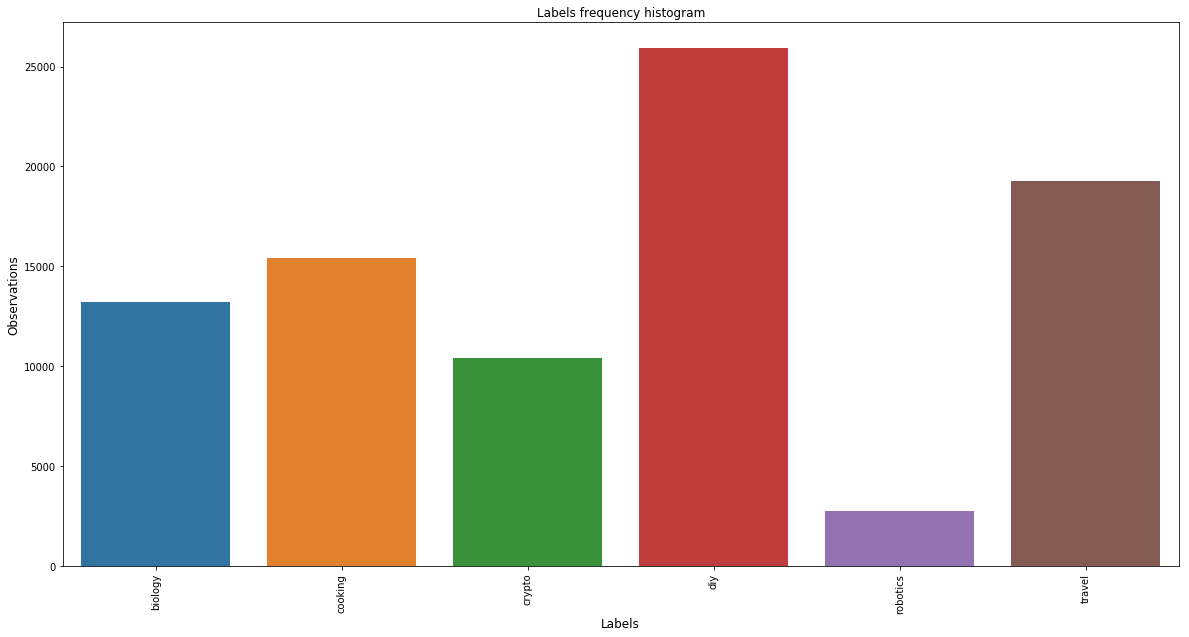

In [6]:
fig = plt.figure(figsize=(20, 10))
ax1 = sns.countplot(dataset['label'].sort_values())
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Labels frequency histogram')
plt.show()

## Word distribution

### Statistics of the number of words (size) of title_content text field

In [7]:
dataset['size'] = dataset['title_content'].apply(lambda x : len(str(x).split()))
sizes = dataset['size'].value_counts()

In [8]:
dataset['size'].describe()
print('The top 20 most frequent size of title_content, and their respective frequency:')
print(sizes.nlargest(20))

The top 20 most frequent size of title_content, and their respective frequency:
44    1065
39    1058
35    1055
42    1053
51    1023
45    1023
47    1016
50    1008
41    1008
37     995
36     989
55     983
38     982
46     978
40     959
33     956
32     953
34     952
31     949
43     948
Name: size, dtype: int64


### Histogram

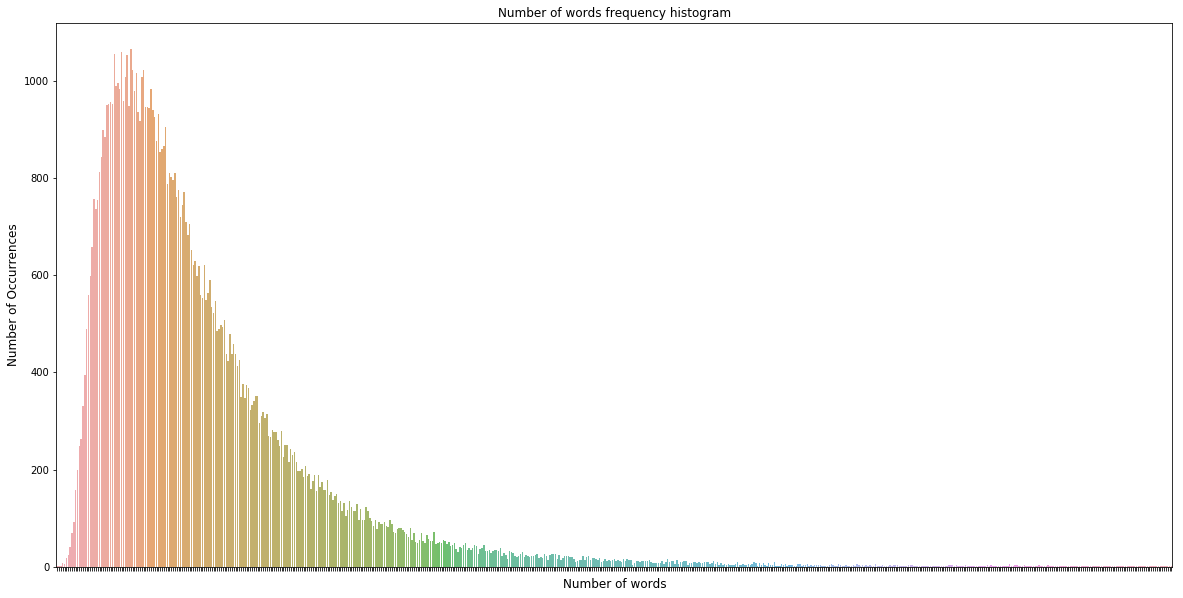

In [9]:
fig = plt.figure(figsize=(20, 10))
ax1 = sns.barplot(sizes.index, sizes.values, alpha=0.8)
ax1.set_xticklabels([])
plt.title('Number of words frequency histogram')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

## Data example

### Robotics texts with more than 200 words

In [10]:
filtered_data = dataset[(dataset.label == 'robotics') & (dataset.title_content.apply(lambda x : len(str(x).split())) > 200)]
filtered_data.describe()

size
count   237.000000
mean    299.438819
std     133.648324
min     201.000000
25%     226.000000
50%     257.000000
75%     318.000000
max    1276.000000

### Cell content example

In [11]:
line=61041
print('TEXT: {0}'.format(dataset.loc[61041, 'title_content']))
print('LABEL: {0}'.format(dataset.loc[61041, 'label']))
print('LENGTH: {0} words.'.format(len(dataset.loc[61041, 'title_content'].split())))

TEXT: visa needed for transit heatrow wife ukrainian citizen with romanian residency permit have tickets for flight madrid heatrow seoul see below details jue iberia turista madrid adolfo rez barajas terminal londres heathrow terminal jue british airways turista londres heathrow terminal seoul incheon want understand she needs transit visa not far that there the datv visa which can used you will not thourgh border control but don know this the case not will not have checkin our luggage but there any other border control that might have pass the terminals will change and not both flights will depart from terminal according this you don need apply for one you have eea family permit which seems the case this situation she not required any visa all
LABEL: travel
LENGTH: 124 words.


# Sampling

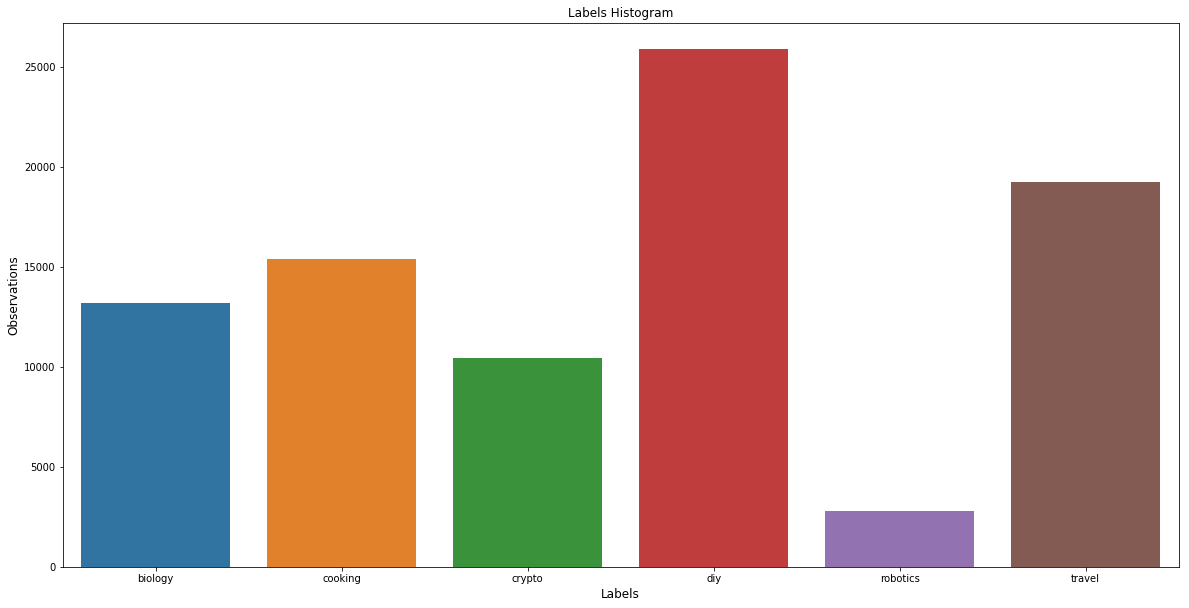

In [12]:
ds = {}
for label in labels.keys():
    ds[label] = dataset[dataset.label == label]
#     ds[label] = resample(ds[label], replace=False, n_samples=labels.min(), random_state=711)
ds = pd.concat(ds[label] for label in ds)

fig = plt.figure(figsize=(20, 10))
ax1 = sns.countplot(ds['label'].sort_values())
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Labels', fontsize=12)
# plt.xticks(rotation='vertical')
plt.title('Labels Histogram')
plt.show()

# Bag-of-Words

In [13]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=STOP_WORDS,
                        ngram_range=(1,1),
                        max_df=0.7, min_df=2,
                        sublinear_tf=True)
X = tfidf.fit_transform(ds['title_content'])
print(X.shape)

l_enc = LabelEncoder()
y = l_enc.fit_transform(ds['label'])
print('Encoded labels: ', list([(i, l_enc.classes_[i]) for i in range(0, len(l_enc.classes_))]))

(87000, 37087)
Encoded labels:  [(0, 'biology'), (1, 'cooking'), (2, 'crypto'), (3, 'diy'), (4, 'robotics'), (5, 'travel')]


# Dimensionality reduction

In [14]:
svd = TruncatedSVD(n_components=1000, algorithm='randomized')
X_svd = svd.fit_transform(X)
print('Shape of svd matrix: ', X_svd.shape)

Shape of svd matrix:  (87000, 1000)


# Split Train/Test examples

In [16]:
# X = np.concatenate([svd_titulo, svd_resumo], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_svd, y, test_size=0.2, random_state=283)

print('X_train matrix shape is: {0}'.format(X_train.shape))
print('X_valid matrix shape is: {0}'.format(X_valid.shape))
print('y_train matrix shape is: {0}'.format(y_train.shape))
print('y_valid matrix shape is: {0}'.format(y_valid.shape))

X_train matrix shape is: (69600, 1000)
X_valid matrix shape is: (17400, 1000)
y_train matrix shape is: (69600,)
y_valid matrix shape is: (17400,)


# Functions

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
      
    plt.figure(figsize=(12,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.title(title + " normalized confusion matrix")
    else:
        plt.title(title + ' confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    

def benchmark(clf, X_train, y_train, X_test, y_test):

    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    print()
    
    clf_descr = str(clf).split('(')[0]
    print("Done with " + clf_descr)
    print('_' * 80)
    
    return clf_descr, score, train_time, test_time

# KFold

In [18]:
kf = StratifiedKFold(n_splits=qtd_splits)

#results = defaultdict(list)
resultsGaussianNB = []
resultsBernoulliNB = []
resultsRandomForest = []
resultsSVM = []


for train, test in kf.split(X_train, y_train):
    resultsGaussianNB.append(benchmark(GaussianNB(), X_train[train], y_train[train], X_train[test], y_train[test]))
    resultsBernoulliNB.append(benchmark(BernoulliNB(), X_train[train], y_train[train], X_train[test], y_train[test]))
    resultsRandomForest.append(benchmark(RandomForestClassifier(), X_train[train], y_train[train], X_train[test], y_train[test]))
    resultsSVM.append(benchmark(svm.LinearSVC(), X_train[train], y_train[train], X_train[test], y_train[test]))

Training: 
GaussianNB(priors=None)
train time: 2.136s
test time:  0.657s
accuracy:   0.801

Done with GaussianNB
________________________________________________________________________________
Training: 
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
train time: 2.676s
test time:  0.301s
accuracy:   0.906

Done with BernoulliNB
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 43.932s
test time:  0.081s
accuracy:   0.916

Done with RandomForestClassifier
_________________________________________

train time: 22.461s
test time:  0.031s
accuracy:   0.976

Done with LinearSVC
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 2.224s
test time:  0.743s
accuracy:   0.800

Done with GaussianNB
________________________________________________________________________________
Training: 
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
train time: 2.653s
test time:  0.296s
accuracy:   0.902

Done with BernoulliNB
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
   

## Naïve-Bayes Gaussian

Accuracy: 0.802816091954023


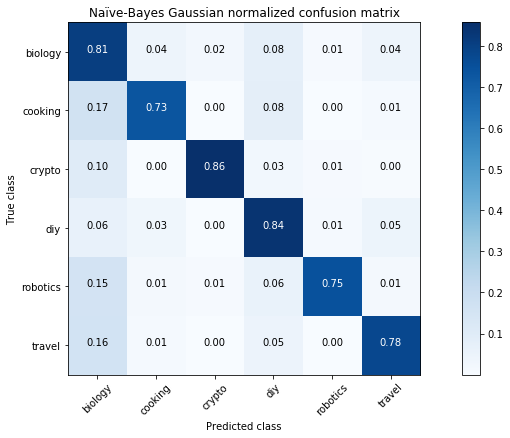

In [19]:
nbg = GaussianNB()
nbg.fit(X_train, y_train)  # ***** substituir pelo melhor fit do Kfold *****
y_pred = nbg.predict(X_valid)                               # já substitui pelo conjunto de validação
cm = confusion_matrix(y_valid, y_pred)                      # já substitui pelo conjunto de validação
print('Accuracy: ' + str(accuracy_score(y_valid, y_pred)))  # já substitui pelo conjunto de validação
plot_confusion_matrix(cm, l_enc.classes_, title='Naïve-Bayes Gaussian', normalize=True)

## Naïve-Bayes Bernoulli

Accuracy: 0.9036781609195402


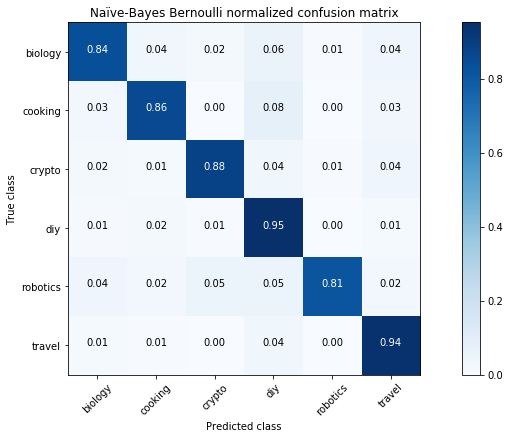

In [20]:
nbb = BernoulliNB()
nbb.fit(X_train, y_train)  # ***** substituir pelo melhor fit do Kfold *****
y_pred = nbb.predict(X_valid)                               # já substitui pelo conjunto de validação
cm = confusion_matrix(y_valid, y_pred)                      # já substitui pelo conjunto de validação
print('Accuracy: ' + str(accuracy_score(y_valid, y_pred)))  # já substitui pelo conjunto de validação
plot_confusion_matrix(cm, l_enc.classes_, title='Naïve-Bayes Bernoulli', normalize=True)

## Random Forest

Accuracy: 0.9092528735632184


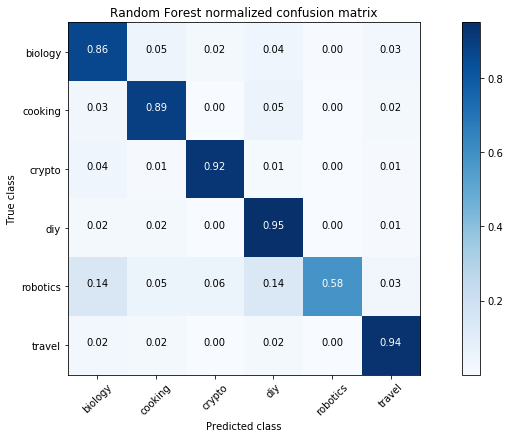

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)  # ***** substituir pelo melhor fit do Kfold *****
y_pred = rf.predict(X_valid)                                # já substitui pelo conjunto de validação
cm = confusion_matrix(y_valid, y_pred)                      # já substitui pelo conjunto de validação
print('Accuracy: ' + str(accuracy_score(y_valid, y_pred)))  # já substitui pelo conjunto de validação
plot_confusion_matrix(cm, l_enc.classes_, title='Random Forest', normalize=True)

## SVM

Accuracy: 0.974367816091954


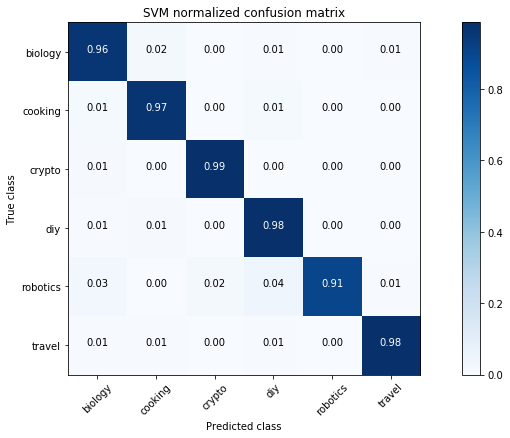

In [22]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train)  # ***** substituir pelo melhor fit do Kfold *****
y_pred = lin_clf.predict(X_valid)                           # já substitui pelo conjunto de validação
cm = confusion_matrix(y_valid, y_pred)                      # já substitui pelo conjunto de validação
print('Accuracy: ' + str(accuracy_score(y_valid, y_pred)))  # já substitui pelo conjunto de validação
plot_confusion_matrix(cm, l_enc.classes_, title='SVM', normalize=True)

## WiSARD

# Pendente!!!

## WiSARD!
## Gráfico da acurácia e dos tempos de treinamento e previsão incluindo o desvio padrão
## Apresentação dos gráficos em figura única
## Como escolher o melhor fit da sequência de k-folds?

# Results - END OF NOTEBOOK

In [ ]:
print(resultsGaussianNB)
print(resultsBernoulliNB)
print(resultsRandomForest)
print(resultsSVM)

indices = np.arange(len(resultsGaussianNB))

resultsGaussianNB = [[x[i] for x in resultsGaussianNB] for i in range(4)]
resultsBernoulliNB = [[x[i] for x in resultsBernoulliNB] for i in range(4)]
resultsRandomForest = [[x[i] for x in resultsRandomForest] for i in range(4)]
resultsSVM = [[x[i] for x in resultsSVM] for i in range(4)]

#ver se a concatenacao foi na direcao certa

clf_names, score, training_time, test_time = resultsGaussianNB + resultsBernoulliNB + resultsRandomForest + resultsSVM

#falta o que fazer com as 4 variaveis acima, e juntar nelas os dados de todos 
#os classificadores pra fazer o grafico unico

print("comeca")
print(training_time)
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

['Gaussian', 'Bernoulli', 'RandomForest', 'SVM']
['GaussianNB', 'GaussianNB', 'GaussianNB', 'GaussianNB', 'GaussianNB', 'GaussianNB', 'GaussianNB', 'GaussianNB', 'GaussianNB', 'GaussianNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'BernoulliNB', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'LinearSVC']


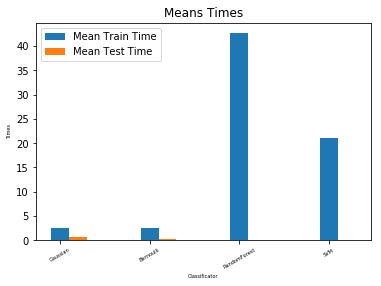

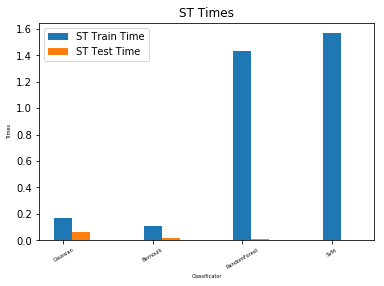

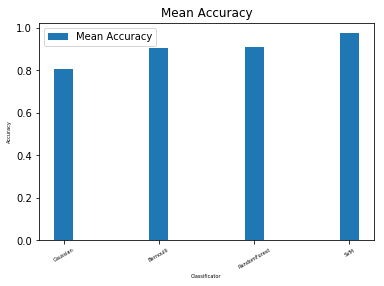

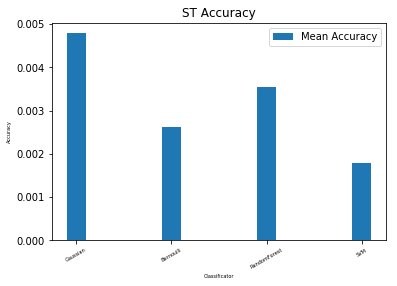

In [23]:
import numpy
#print(resultsGaussianNB)
#print(resultsBernoulliNB)
#print(resultsRandomForest)
#print(resultsSVM)

#TODO para cada um dos arrays acima, juntar ja os valores pra media e dp de cada metrica. São arrays de 4-tuplas


h = [[x[i] for x in resultsGaussianNB] for i in range(4)]
a, b, c, d = h

arr = numpy.array(b)
meanresultsGaussianNBAccuracy = numpy.mean(arr, axis=0)
sdresultsGaussianNBAccuracy = numpy.std(arr, axis=0)
arr = numpy.array(c)
meanresultsGaussianNBTrain = numpy.mean(arr, axis=0)
sdresultsGaussianNBTrain = numpy.std(arr, axis=0)
arr = numpy.array(d)
meanresultsGaussianNBTest = numpy.mean(arr, axis=0)
sdresultsGaussianNBTest = numpy.std(arr, axis=0)


h = [[x[i] for x in resultsBernoulliNB] for i in range(4)]
a, b, c, d = h

arr = numpy.array(b)
meanresultsBernoulliNBAccuracy = numpy.mean(arr, axis=0)
sdresultsBernoulliNBAccuracy = numpy.std(arr, axis=0)
arr = numpy.array(c)
meanresultsBernoulliNBTrain = numpy.mean(arr, axis=0)
sdresultsBernoulliNBTrain = numpy.std(arr, axis=0)
arr = numpy.array(d)
meanresultsBernoulliNBTest = numpy.mean(arr, axis=0)
sdresultsBernoulliNBTest = numpy.std(arr, axis=0)

h = [[x[i] for x in resultsRandomForest] for i in range(4)]
a, b, c, d = h

arr = numpy.array(b)
meanresultsRandomForestAccuracy = numpy.mean(arr, axis=0)
sdresultsRandomForestAccuracy = numpy.std(arr, axis=0)
arr = numpy.array(c)
meanresultsRandomForestTrain = numpy.mean(arr, axis=0)
sdresultsRandomForestTrain = numpy.std(arr, axis=0)
arr = numpy.array(d)
meanresultsRandomForestTest = numpy.mean(arr, axis=0)
sdresultsRandomForestTest = numpy.std(arr, axis=0)

h = [[x[i] for x in resultsSVM] for i in range(4)]
a, b, c, d = h

arr = numpy.array(b)
meanresultsSVMAccuracy = numpy.mean(arr, axis=0)
sdresultsSVMAccuracy = numpy.std(arr, axis=0)
arr = numpy.array(c)
meanresultsSVMTrain = numpy.mean(arr, axis=0)
sdresultsSVMTrain = numpy.std(arr, axis=0)
arr = numpy.array(d)
meanresultsSVMTest = numpy.mean(arr, axis=0)
sdresultsSVMTest = numpy.std(arr, axis=0)

#ver se a concatenacao foi na direcao certa
results = resultsGaussianNB + resultsBernoulliNB + resultsRandomForest + resultsSVM

#print("era assim")
#print(results)

indices = np.arange(len(results))

#resultsGaussianNB2 = [[x[i] for x in resultsGaussianNB] for i in range(4)]
#resultsBernoulliNB2 = [[x[i] for x in resultsBernoulliNB] for i in range(4)]
#resultsRandomForest2 = [[x[i] for x in resultsRandomForest] for i in range(4)]
#resultsSVM2 = [[x[i] for x in resultsSVM] for i in range(4)]

resultsFinal = [[x[i] for x in results] for i in range(4)]
#print("ficou assim")
#print(resultsFinal)

clf_names, score, training_time, test_time = resultsFinal
labels = ["Gaussian", "Bernoulli", "RandomForest", "SVM"]
print(labels)
print(clf_names)
indicesNew = np.arange(len(labels))
meanScore = meanresultsGaussianNBAccuracy, meanresultsBernoulliNBAccuracy, meanresultsRandomForestAccuracy, meanresultsSVMAccuracy
meanDPScore = sdresultsGaussianNBAccuracy, sdresultsBernoulliNBAccuracy, sdresultsRandomForestAccuracy, sdresultsSVMAccuracy
meanTrain = meanresultsBernoulliNBTrain, meanresultsBernoulliNBTrain, meanresultsRandomForestTrain, meanresultsSVMTrain
meanDPTrain = sdresultsGaussianNBTrain, sdresultsBernoulliNBTrain, sdresultsRandomForestTrain, sdresultsSVMTrain
meanTest = meanresultsGaussianNBTest, meanresultsBernoulliNBTest, meanresultsRandomForestTest, meanresultsSVMTest
meanDPTest = sdresultsGaussianNBTest, sdresultsBernoulliNBTest, sdresultsRandomForestTest, sdresultsSVMTest

########Tempos

plt.bar(indicesNew, meanTrain, width=0.2, label="Mean Train Time")
plt.bar(indicesNew + .2, meanTest, width=0.2, label="Mean Test Time")
plt.xlabel('Classificator', fontsize=5)
plt.ylabel('Times', fontsize=5)
plt.xticks(indicesNew, labels, fontsize=5, rotation=30)
plt.title('Means Times')
plt.legend(loc='best')
plt.show()

#########STTempos

plt.bar(indicesNew, meanDPTrain, width=0.2, label="ST Train Time")
plt.bar(indicesNew + .2, meanDPTest, width=0.2, label="ST Test Time")
plt.xlabel('Classificator', fontsize=5)
plt.ylabel('Times', fontsize=5)
plt.xticks(indicesNew, labels, fontsize=5, rotation=30)
plt.title('ST Times')
plt.legend(loc='best')
plt.show()

########## Accuracy

plt.bar(indicesNew, meanScore, width=0.2, label="Mean Accuracy")
plt.xlabel('Classificator', fontsize=5)
plt.ylabel('Accuracy', fontsize=5)
plt.xticks(indicesNew, labels, fontsize=5, rotation=30)
plt.title('Mean Accuracy')
plt.legend(loc='best')
plt.show()

########## ST Accuracy

plt.bar(indicesNew, meanDPScore, width=0.2, label="Mean Accuracy")
plt.xlabel('Classificator', fontsize=5)
plt.ylabel('Accuracy', fontsize=5)
plt.xticks(indicesNew, labels, fontsize=5, rotation=30)
plt.title('ST Accuracy')
plt.legend(loc='best')
plt.show()



